In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# import libraries

In [2]:
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import data

In [3]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/kaggle/input/fyp-dataset/non_demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/fyp-dataset/very_mild_demented'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/fyp-dataset/mild_demented'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/fyp-dataset/moderate_demented'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

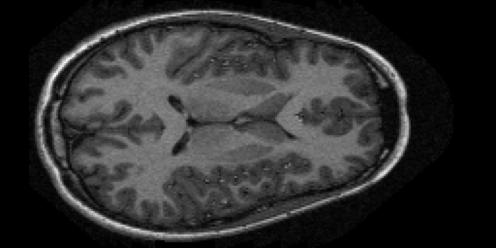

In [4]:
PIL.Image.open(str(non_demented[0]))

In [5]:
print(len(non_demented))
print(len(mild_demented))
print(len(moderate_demented))
print(len(very_mild_demented))

5000
5000
5000
5000


## **making a new dataset using minimum number of images contain in a category among all the category**

## One Hot Encoding
* 0 -> non_demented
* 1 -> mild_dementia
* 2 -> moderate_dementia
* 3 -> very_mild_dementia

In [6]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

## Data proccessing
### transfer data into 128x128x3 shape

In [7]:
data = []
result = []
for s in non_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
        
for s in mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for s in moderate_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for s in very_mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())


### Reshape the data

In [8]:
X=np.array(data)


In [12]:
X.shape

(20000, 128, 128, 3)

In [9]:
y=np.array(result)
y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)
y

array([0, 0, 0, ..., 3, 3, 3])

# splitting the data

In [10]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.shape

(16000, 128, 128, 3)

In [13]:
X_test.shape

(4000, 128, 128, 3)

# Creating Model


In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

vgg16 = VGG16(include_top=False, input_shape=(128, 128, 3), weights=None)

# Create a new model
model_vgg16 = Sequential()

# Add the VGG19 convolutional base
model_vgg16.add(vgg16)

# Add custom dense layers
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model_vgg16.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 16813124 (64.14 MB)
Trainable params: 16813124 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [15]:
history= model_vgg16.fit(X_train,y_train, validation_split=0.2,epochs=30,callbacks=[early_stopping],batch_size=32)

Epoch 1/30
400/400 [==============================] - 40s 79ms/step - loss: 1.9185 - accuracy: 0.4068 - val_loss: 1.0914 - val_accuracy: 0.4697
Epoch 2/30
400/400 [==============================] - 31s 77ms/step - loss: 0.8988 - accuracy: 0.5802 - val_loss: 0.7569 - val_accuracy: 0.6488
Epoch 3/30
400/400 [==============================] - 31s 77ms/step - loss: 0.6324 - accuracy: 0.7277 - val_loss: 0.5412 - val_accuracy: 0.7741
Epoch 4/30
400/400 [==============================] - 31s 77ms/step - loss: 0.4521 - accuracy: 0.8141 - val_loss: 0.4312 - val_accuracy: 0.8344
Epoch 5/30
400/400 [==============================] - 31s 77ms/step - loss: 0.3421 - accuracy: 0.8635 - val_loss: 0.4557 - val_accuracy: 0.8184
Epoch 6/30
400/400 [==============================] - 31s 77ms/step - loss: 0.2644 - accuracy: 0.8991 - val_loss: 0.3530 - val_accuracy: 0.8716
Epoch 7/30
400/400 [==============================] - 31s 77ms/step - loss: 0.2501 - accuracy: 0.9022 - val_loss: 0.2527 - val_accuracy:

In [23]:
score = model_vgg16.evaluate(X_test,y_test)
test_loss = score[0] * 100
test_accuracy = score[1] * 100

print('Test Loss = {:.2f}'.format(test_loss))
print('Test Accuracy = {:.2f}%'.format(test_accuracy))

125/125 [==============================] - 3s 21ms/step - loss: 1.3738 - accuracy: 0.2578
Test Loss = 137.38
Test Accuracy = 25.78%


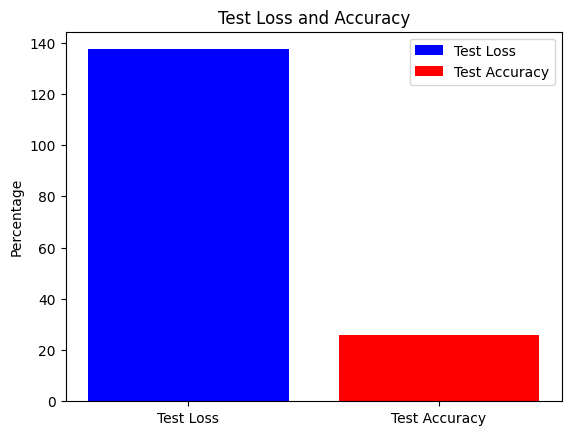

In [18]:
# Plotting
fig, ax = plt.subplots()

# Plot test loss
ax.bar('Test Loss', test_loss, color='b', label='Test Loss')
# Plot test accuracy
ax.bar('Test Accuracy', test_accuracy, color='r', label='Test Accuracy')

# Adding labels
ax.set_ylabel('Percentage')
ax.set_title('Test Loss and Accuracy')
ax.legend()

# Show plot
plt.show()

125/125 [==============================] - 3s 20ms/step
Test Accuracy = 0.26


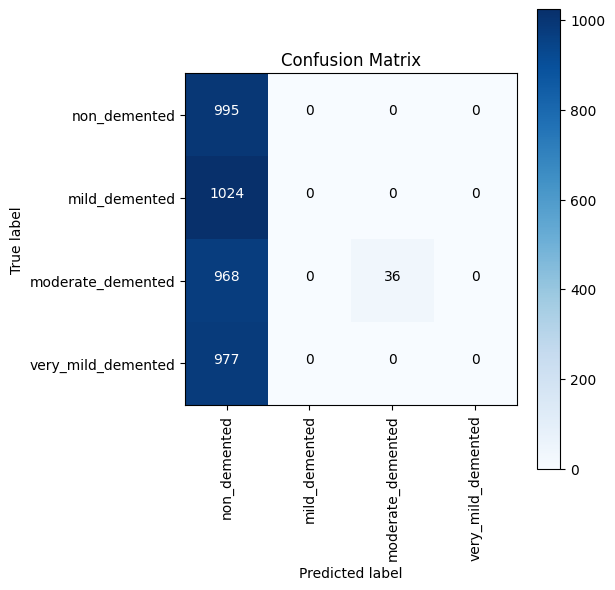

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Assuming model.predict(X_test) returns predictions and y_test is the true labels
predictions = model_vgg16.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred) 

# Define test_labels
test_labels = {0: 'non_demented', 1: 'mild_demented', 2: 'moderate_demented', 3: 'very_mild_demented'}

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    pass

cm = plot_confusion_matrix(confusion_mtx, classes=list(test_labels.values()), normalize=False)


In [21]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=list(test_labels.values())))

                    precision    recall  f1-score   support

      non_demented       0.25      1.00      0.40       995
     mild_demented       0.00      0.00      0.00      1024
 moderate_demented       1.00      0.04      0.07      1004
very_mild_demented       0.00      0.00      0.00       977

          accuracy                           0.26      4000
         macro avg       0.31      0.26      0.12      4000
      weighted avg       0.31      0.26      0.12      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


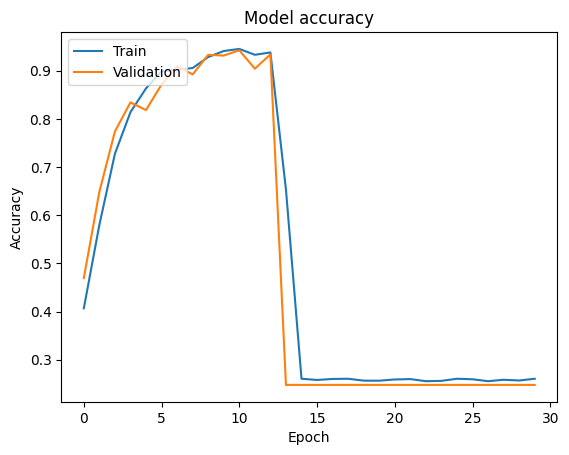

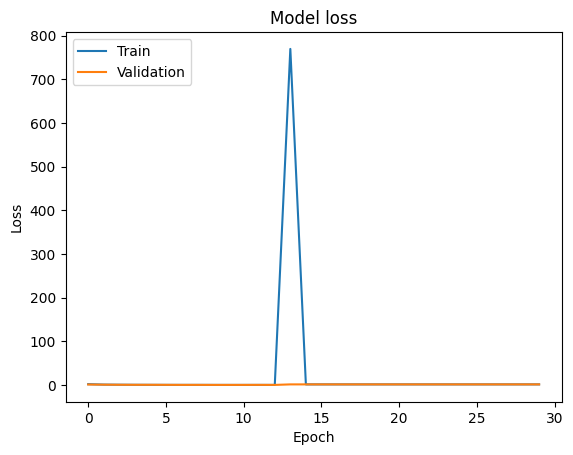

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model=Sequential()

In [ ]:
model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

In [ ]:
model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4,activation='sigmoid'))

In [ ]:
print(model.summary())

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
history= model.fit(X_train,y_train, validation_split=0.2,epochs=50,callbacks=[early_stopping],batch_size=32)

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    plt.imshow(img)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
image_path = "/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0001_MR1_mpr-1_115.jpg"
image_array = preprocess_image(image_path)
print("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
prediction_probabilities = model.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labels
class_labels = ['non_demented', 'mild_demented', 'moderate_demented', 'very_mild_demented']

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

print("Predicted class:", predicted_class)


In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

test_labels = {0: 'non_demented', 1: 'mild_demented', 2: 'moderate_demented', 3: 'very_mild_demented'}

accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.values()), normalize=False)

In [ ]:
from sklearn.metrics import classification_report

target_names = list(test_labels.values())
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
%matplotlib inline 
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [ ]:
model.save('my_model1.h5')

**Lenet**

In [ ]:
new_model = tf.keras.models.load_model('/kaggle/input/alzheimer-detection-using-cnn/my_model.keras')

In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, target_size=(128, 128)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
image_path = "/kaggle/input/testing/Untitleqd-1.png"
image_array = preprocess_image(image_path)
print("Shape of preprocessed image array:", image_array.shape)


In [ ]:
new_model.predict(image_array)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from flask import Flask, request, jsonify


app = Flask(__name__)

# Load the Keras model
model = tf.keras.models.load_model('/kaggle/input/alzheimer-detection-using-cnn/my_model.keras')
print('Model loaded')



In [ ]:
!python --version

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Load the Keras model
model = tf.keras.models.load_model('/kaggle/input/alzheimer-detection-using-cnn/my_model.keras')
print('Model loaded')



In [ ]:
%pip show sklearn

In [ ]:
model.predict(image_array)